<a href="https://colab.research.google.com/github/JYL480/ReplicateViTPaper/blob/main/ReplicatingVIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The MLP contains two layers with a GELU non-linearity.
$$
\begin{aligned}
\mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{p o s}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{p o s} \in \mathbb{R}^{(N+1) \times D} \\
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \\
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_L^0\right) & &
\end{aligned}
$$

- This will be the 4 equations within the encoder block!

# Assumptions or Inductive Biad of Traditional CNN and ViT

Inductive Bias in Vision Transformer (ViT) vs. CNNs

## Inductive Bias in CNNs:

- Locality: CNNs operate on small local patches of the image, leveraging the fact that pixels close to each other are more likely to be related.
- Two-dimensional Neighborhood Structure: CNNs use 2D convolutions that respect the spatial arrangement of the image.
- Translation Equivariance: CNNs produce similar results if the input image is translated (shifted) because of the convolution operation.

## Inductive Bias in ViT:

Less Image-Specific Inductive Bias: ViT does not inherently leverage the same assumptions about the spatial structure of images as CNNs do.
- Global Self-Attention: The self-attention mechanism in ViT can attend to all patches globally, not just local neighborhoods.
- Local MLP Layers: The Multi-Layer Perceptron (MLP) layers in ViT operate locally and maintain translation equivariance.
- Sparse Use of 2D Neighborhood Structure:
At the Beginning: The image is divided into patches, which introduces some initial 2D structure.
Position Embeddings: During initialization, position embeddings are added to the patches. However, these embeddings do not carry explicit information about the 2D positions; this must be learned during training.
Fine-Tuning: Position embeddings may be adjusted for different image resolutions during fine-tuning.

# Training Parameters
- Batch size = 4096, BUT WE CANT USE IT HERE LOL
- Learning rate warmup = 10,000
- Training Resolution / Image size = 224 x 224 (Transformation)
- Optimizer = Adam, Decay rate = (0.9 , 0.999) Default for PyTorch, Weight Decay = 0.1
- Patch Resolution will be based off the model. Eg, ViT-B/16 means 16 x 16

# Fine Tuning

- Batch size = 512
- Optimizer = SGD with momentum

## Overall Hyperparameters used

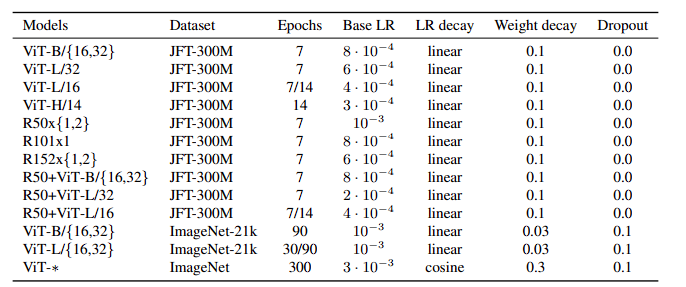

----------------------------------
# Start by replicating ViT-B/16

In [1]:
# Import all the necessary things

# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.3.1+cu121
torchvision version: 0.18.1+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 29.77 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [3]:
# Start with 3 classes, Pizza, sushi and steak
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [4]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [5]:
# Because the training resolution = 224 x 224, we will have to resize the image with transform!

IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [6]:
# Get the datasets and place it into the dataloaders!
# Because the directory is already in the format we want!!
# Lets create the dataset first oursleuf then load it into the dataloader!

from torchvision import datasets, transforms

train_data = datasets.ImageFolder(train_dir, transform=manual_transforms)
test_data = datasets.ImageFolder(test_dir, transform=manual_transforms)

train_data.class_to_idx
# Note that you can also create your own!!

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [7]:
# Load these data into the dataloader!
# Here you also should use pin_memory = TRUE!!!!!! <-------------------

from torch.utils.data import DataLoader
import os

BATCH_SIZE = 32 #We cant follow their batch size of 4096 as we are using colab's RAM which is not enough! LEts use 32 lol

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True, pin_memory=True,)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=False,  pin_memory=True,)

In [8]:
# You can test out inside
# In here there will be batch of 32 things!!
# Also from the dataloader, it will return us 2 things, the tensor and labels!

next(iter(train_dataloader))

[tensor([[[[0.2549, 0.2588, 0.2824,  ..., 0.2118, 0.2039, 0.1882],
           [0.2627, 0.2627, 0.2745,  ..., 0.2235, 0.2157, 0.2039],
           [0.2627, 0.2667, 0.2627,  ..., 0.2196, 0.2196, 0.2078],
           ...,
           [0.4118, 0.4118, 0.4157,  ..., 0.1333, 0.1412, 0.1333],
           [0.3882, 0.4000, 0.4118,  ..., 0.1176, 0.1216, 0.1255],
           [0.3882, 0.3922, 0.4000,  ..., 0.1216, 0.1176, 0.1216]],
 
          [[0.2667, 0.2627, 0.2784,  ..., 0.2392, 0.2353, 0.2235],
           [0.2824, 0.2745, 0.2706,  ..., 0.2510, 0.2471, 0.2471],
           [0.2863, 0.2824, 0.2667,  ..., 0.2549, 0.2549, 0.2510],
           ...,
           [0.2745, 0.2745, 0.2784,  ..., 0.1804, 0.1882, 0.1804],
           [0.2588, 0.2667, 0.2784,  ..., 0.1647, 0.1647, 0.1569],
           [0.2588, 0.2627, 0.2706,  ..., 0.1608, 0.1608, 0.1490]],
 
          [[0.2392, 0.2353, 0.2353,  ..., 0.2627, 0.2706, 0.2784],
           [0.2588, 0.2431, 0.2314,  ..., 0.2745, 0.2784, 0.2706],
           [0.2627, 0.25

# To reshape the image based on the embeddings

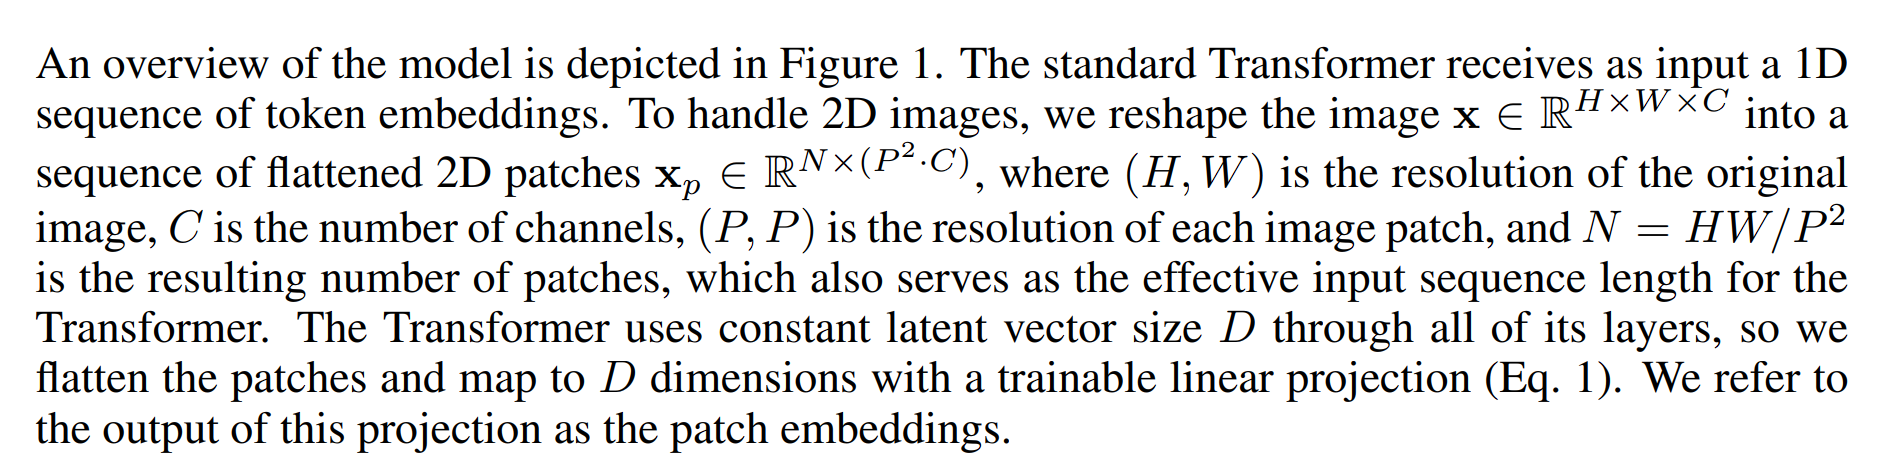

In [9]:
# Get the class names

class_names = train_dataloader.dataset.classes
class_names[1]

'steak'

In [10]:
# Reshapeing of image
# Based on the hyper params of training

height = 224
width = 224
colour_channels = 3
patch_size = 16 # p

#num_patches = N
num_patches = int((height * width)/ patch_size**2)
print(f"Number of patches , N = {num_patches}")

# 2nd dim value = p^2 x c
sec_value = patch_size**2 * colour_channels
new_shape = (num_patches, sec_value)
print(f"Old shape of imge = (244, 244, 3)")
print(f"New shape of image = {new_shape}")

Number of patches , N = 196
Old shape of imge = (244, 244, 3)
New shape of image = (196, 768)


## Now we will try to divide an image into patches based on the resolution of patches 16x16

tensor(2)


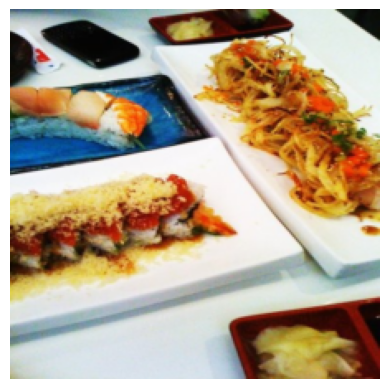

In [11]:
# Lets get an image from the dataloader
torch.manual_seed(42)
image_T, label = next(iter(train_dataloader))
image_T[0].shape
# It is in Batch, C, H, W -> h W C
# use permute so that we acn use matplotlib to show
image = image_T[0]
label_image = label[0]
plt.imshow(image.permute(1, 2, 0))
plt.axis(False)
print(label_image)

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


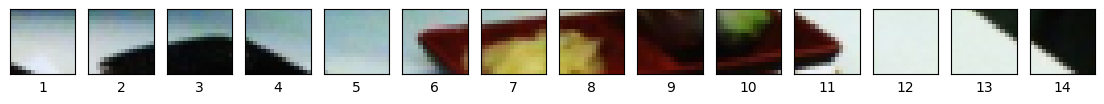

In [12]:
image_permuted = image.permute(1, 2, 0)

img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

- If want to do the whole picture, we would have to nested for loop!

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


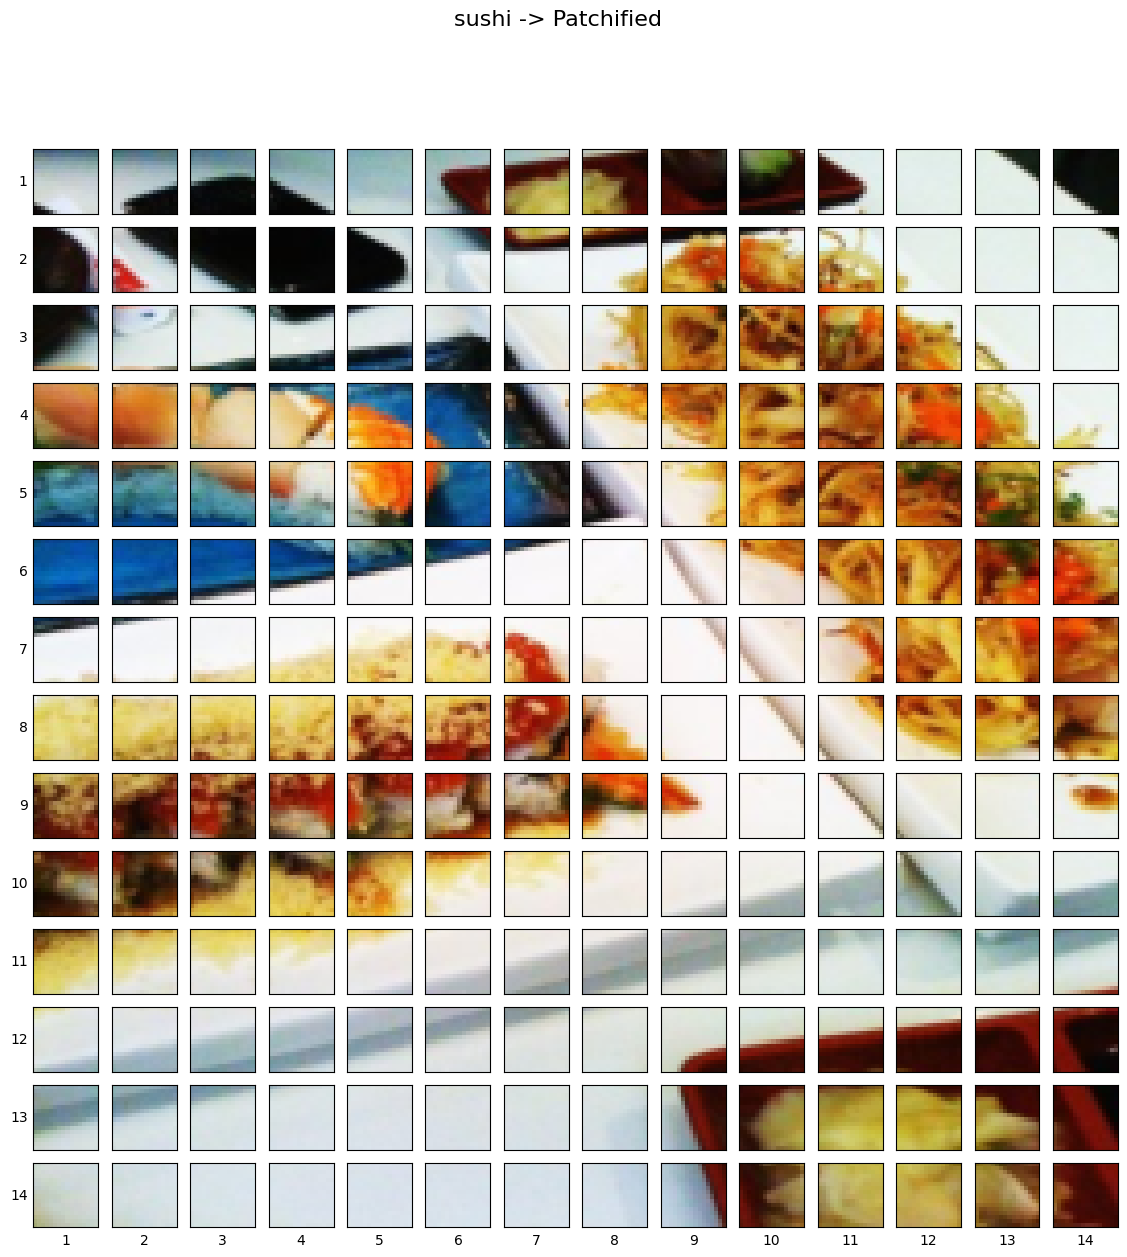

In [13]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch_h in enumerate(range(0, img_size, patch_size)):
  for j, patch_w in enumerate(range(0,img_size, patch_size)):
    axs[i, j].imshow(image_permuted[patch_h:patch_h+patch_size, patch_w:patch_w+patch_size, :])
    axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label_image]} -> Patchified", fontsize=16)
plt.show()

# We can patchify with Conv2d instead which was mention in the paper!


We can replicate the creation of patches by setting the kernel_size and stride equal to patch_size.

This means each convolutional kernel will be of size (patch_size x patch_size) or if patch_size=16, (16 x 16) (the equivalent of one whole patch).

And each step or stride of the convolutional kernel will be patch_size pixels long or 16 pixels long (equivalent of stepping to the next patch).

We'll set in_channels=3 for the number of color channels in our image and we'll set out_channels=768, the same as the  
D
  value in Table 1 for ViT-Base (this is the embedding dimension, each image will be embedded into a learnable vector of size 768).

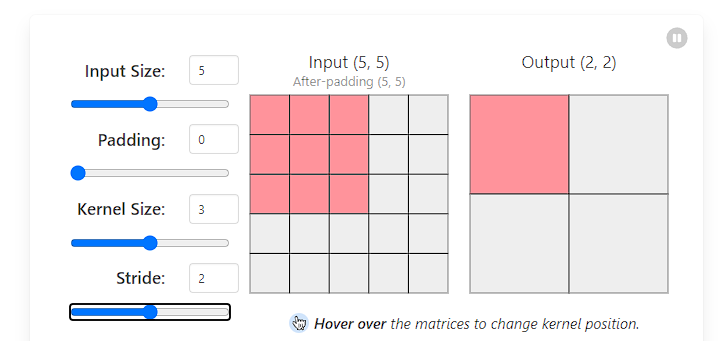

In [14]:
# We will use conv2d such that we can get patches from the image!

from torch import nn

patch_size = 16

# Because the input image shape = (224,224,3)
# Parameters of conv2d!!
# in_channels (int) – Number of channels in the input image

# out_channels (int) – Number of channels produced by the convolution

# kernel_size (int or tuple) – Size of the convolving kernel

# stride (int or tuple, optional) – Stride of the convolution. Default: 1

# number of channels from the output = 768 now because the output shape has to change to (196, 768)
conv2d = nn.Conv2d(3, 768, patch_size, patch_size)
image.shape

torch.Size([3, 224, 224])

In [15]:
# We will try to pass the an image through this layer!!
# Note thaht input of conv2d layer must == (NCHW), there needs to be batch so we will unsqueeze at dim = 0
image_output_conv = conv2d(image.unsqueeze(0))
image_output_conv.shape

torch.Size([1, 768, 14, 14])

In [16]:
print("[Batch, embedding_dim, featuremap_height, featuremap_width ]")
# Embdedding_dim is the number of feature maps extracted from that 1 image!!! This makes sense also as it is the output!

[Batch, embedding_dim, featuremap_height, featuremap_width ]


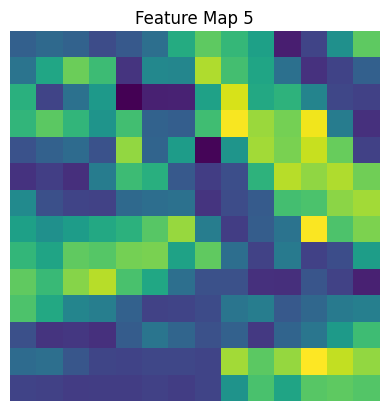

In [17]:

image_conv_feature_map = image_output_conv[:, 5, :, :]

# Squeeze the tensor to remove the batch dimension and convert to numpy array
feature_map_numpy = image_conv_feature_map.squeeze().detach().numpy()

# Visualize the feature map
plt.imshow(feature_map_numpy, cmap='viridis')
plt.title('Feature Map 5')
plt.axis('off')
plt.show()

- Above here is one if the feature map, where features are extracted from that 1 image.
- Note that feature maps are learnable embeddings!!
- So overtime the maps and features will change!

---------
# Now instead of flattening ourselves with the manual calculation, we will use torch.nn.Flatten()

Desired output (1D sequence of flattened 2D patches): (196, 768) -> (number of patches, embedding dimension) ->  
N
×
(
P
2
⋅
C
)

In [18]:
# since we have shape of torch.Size([1, 768, 14, 14])
# We somehow have to convert that to [196, 768], note that 14 x 14 = 196
# nn.Flatenn() can help to multipy the difference dimension of your choice
# we then can permute and unsequeenze to get what we want!

flatten = nn.Flatten(start_dim=2, end_dim =3)

image_out_of_conv_flattened = flatten(image_output_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Flattened image feature map shape: torch.Size([1, 768, 196])


In [19]:
# Now we will permte to look like the desired shape!
image_out_of_conv_flattened_reshaped =  image_out_of_conv_flattened.permute(0, 2, 1)
print(f"Reshaped image feature map shape: {image_out_of_conv_flattened_reshaped.shape}")

Reshaped image feature map shape: torch.Size([1, 196, 768])


- With above, we know have gotten the sequence of flattened 2D patches in the correct shape that we want!
- It seems like we have to prepend a learnable embeddding to the sequence of embedded patches!

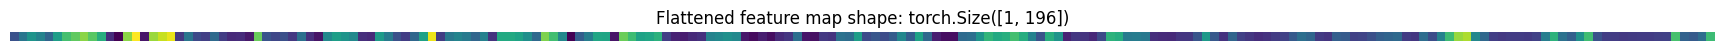

In [20]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

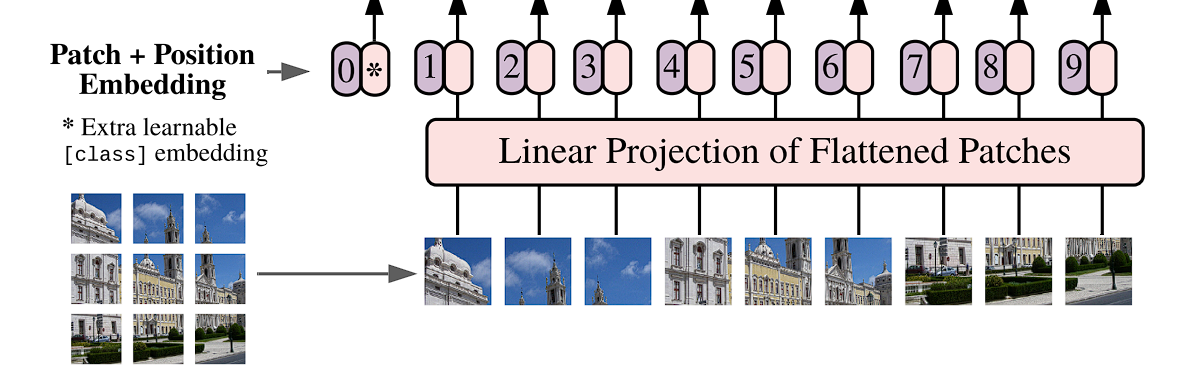

- The flattened feature map image is what we are trying to the achecive after the linear projection of flattened patches!
- We have turn our 2D image in to a 1D sequnec of flattened 2D patches! Which is want the input to the encoder wants!

## To consildate eveything we will place the patchifying and flatten into a class with a function to do some using the forward method (which will be called when intialised the layer)

In [21]:
# Create a class with forward pass and all the other attributes inside!
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels= 3, patch_size= 16, embedding_dim = 768, padding=0):
      super().__init__()

      self.patcher = conv2d = nn.Conv2d(in_channels,embedding_dim, patch_size, patch_size) #padding is default 0

      self.flatten = nn.Flatten(start_dim = 2, end_dim = 3)

    # Lol the forward pass is on the outside,
    # The above __init__ is for the attributes!
    def forward(self, input_2D_image):
      # For checking
      image_resolution = input_2D_image.shape[-1]
      assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
      input_2D_image = self.patcher(input_2D_image)
      input_2D_image = self.flatten(input_2D_image)
      input_2D_image = input_2D_image.permute(0,2,1)
      return input_2D_image


In [22]:
torch.manual_seed(42)

# Get an instanec of the class!
patchify = PatchEmbedding()

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


### What is learnable parameter in pytorch?
- We can use nn.Parameter, where a tensor can be made where it can be learned!
- requires_grad = True, where gradient descent can happen!

Note: Here we're only creating the class token embedding as torch.ones() for demonstration purposes, in reality, you'd likely create the class token embedding with torch.randn() (since machine learning is all about harnessing the power of controlled randomness, you generally start with a random number and improve it over time


## Better to use torch.rand!!!

In [23]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
print(batch_size, embedding_dimension)

1 768


In [24]:
ones = torch.ones(batch_size, 1, embedding_dimension)
ones.shape

torch.Size([1, 1, 768])

In [25]:
# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Note that with requires_grad = True, this is important!!
print(class_token.shape)
# Note that your learnable embedding has to be of the same size as well!

torch.Size([1, 1, 768])


In [26]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
# The class token thing is add at the very beginning!
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.8102,  0.1702, -0.2472,  ...,  0.5219, -0.3046,  0.3604],
         [-0.7466,  0.1335, -0.0461,  ...,  0.1018, -0.0974,  0.2948],
         ...,
         [-0.6009,  0.1046, -0.2139,  ...,  0.4524, -0.3220,  0.2710],
         [-0.5200,  0.0405, -0.1058,  ...,  0.3475, -0.2107,  0.1108],
         [-0.1445,  0.0100, -0.0936,  ..., -0.0249, -0.1222,  0.1604]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


## Im assumming this class token thing is quite common, so take note of it!

-------

## Now we got to the LEARNABLE positional embeddings
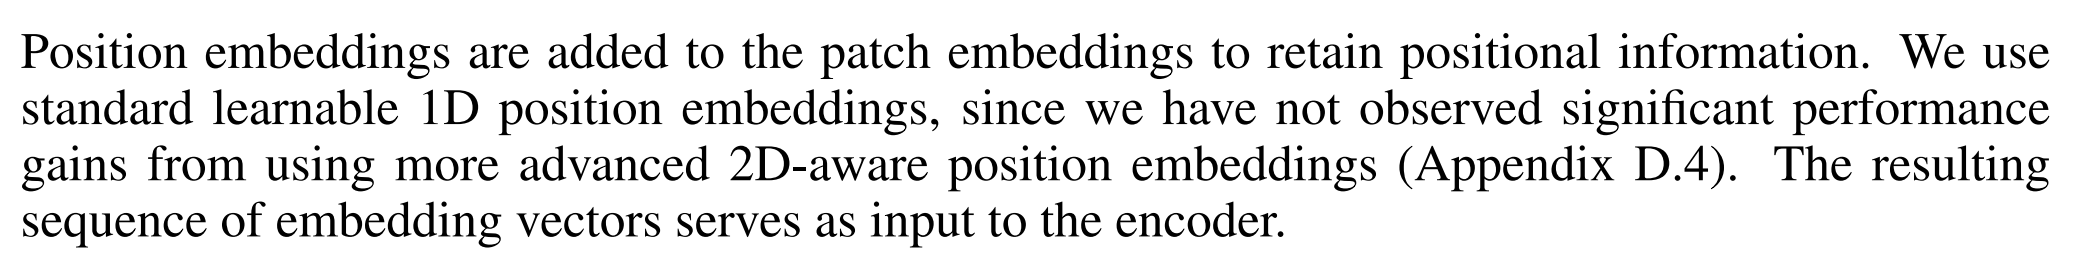

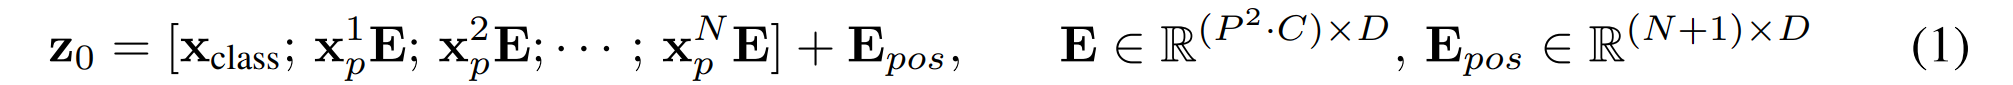

Which is the Epos

In [27]:
# So for positional we also can use torch.ones to start off!
# Then we will Epos + the concatenated class_tokens and patched embeddings!
number_of_patches = int((height * width) / patch_size**2)


In [28]:
# Note that when we cat, the things have to be of the same shape hor!
# We will add the positional embeddings to all! IT should be same dimenesion as the patches!
ones = torch.ones(1, number_of_patches+1, embedding_dimension)
# Then you will pass this ones into a nn.parameter to make it learnable

positional_embedding = nn.Parameter(ones,requires_grad=True)

positional_embedding.shape

torch.Size([1, 197, 768])

In [29]:
# Based on the formulat above where you add the positional embedding and and the class token and patches with learnable embeddinging
patch_and_position_embedding = patch_embedded_image_with_class_embedding + positional_embedding


patch_embedded_image_with_class_embedding[:,:,10], patch_and_position_embedding[:,:,10]

(tensor([[ 1.0000, -0.1905, -0.2225, -0.2246, -0.1510, -0.0818, -0.0747, -0.0668,
          -0.1204, -0.0377, -0.0695, -0.0128, -0.1996, -0.0255,  0.0377, -0.1718,
          -0.0545,  0.0073, -0.0023, -0.1227, -0.0580, -0.0503, -0.1933, -0.4070,
          -0.4909, -0.3451, -0.2517, -0.2047, -0.2553,  0.1342, -0.1496, -0.1247,
          -0.2391, -0.5160, -0.3125, -0.2993, -0.2630, -0.2970, -0.2613, -0.2984,
          -0.4153, -0.2568, -0.2113, -0.3400, -0.4649, -0.3006, -0.4166, -0.0844,
           0.2042, -0.0245, -0.3143, -0.3255, -0.4656, -0.3802, -0.4603, -0.3402,
          -0.2098, -0.0213,  0.0182, -0.0295, -0.2664, -0.4822,  0.0375,  0.1272,
          -0.2684, -0.3870, -0.3657, -0.4167, -0.1091, -0.3161, -0.3407,  0.2157,
           0.2199,  0.0732,  0.3211,  0.1663, -0.1279, -0.2274, -0.2218, -0.1658,
          -0.2109, -0.3761, -0.4848, -0.1959, -0.3846, -0.2393, -0.2587, -0.2190,
          -0.3031, -0.3164, -0.3364, -0.2155, -0.2541, -0.1735, -0.2323, -0.2721,
          -0.507

- Notice the differnece between the top and bottom, you add + 1 to all tensors
- So now you haev both learnable positional embeddings and learnable class tokens with patches of the image

-----
# Moving on to equation 2!

- Should be easier we can just use torch.MSA layer to do it!
- And also torch.layernorm

- 12 MSA HEADS!

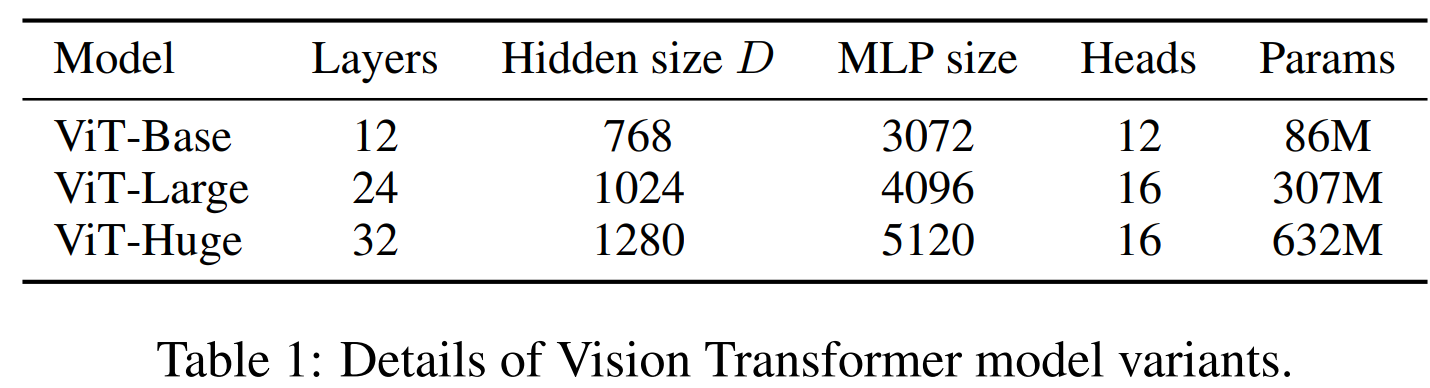

##  Rmb that in a MSA layer K, Q and V are used and pass through a sealed dot product attention

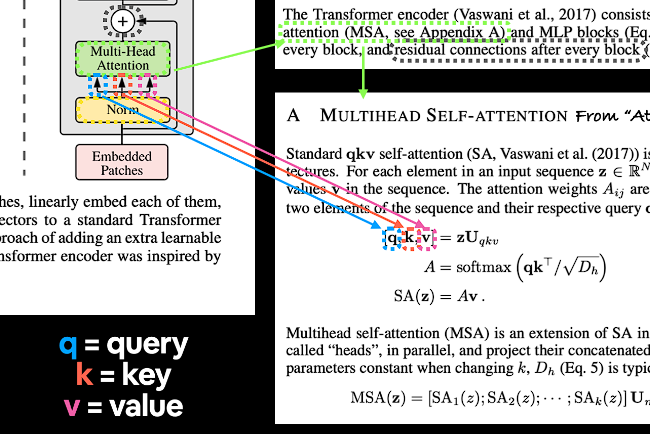

## Here the output of the layer norm is passed to 3 input parameters!! QKV, hence in the forward pass it will be as such!

In [30]:
# We will now create a class for the MSA and Norm block for equation 2!!

class MSAwNorm(nn.Module):
  def __init__(self, embedding_dimension = 768, num_heads = 12):
    super().__init__()

    # your attributes
    self.msa = nn.MultiheadAttention(embed_dim = embedding_dimension,num_heads = num_heads, batch_first=True)
    self.norm = nn.LayerNorm(embedding_dimension)

    # forward pass
  def forward(self, x):
    x = self.norm(x)
    # Note that the intput to query, key and value are all the same!
    attn_output, _ = self.msa(query = x, key= x, value= x, need_weights = False) #We dont need the weights, so it will not return anything "_" for the 2nd param
    return attn_output

# Note attenetion_ouput is just tensors oso!! It should have the same shape, but generearlly different values

In [31]:
# Create an instance of the class first

MSA_head = MSAwNorm() #Have default values inside, take note!

patched_image_through_MSA = MSA_head(patch_and_position_embedding)
print("Equation 1 Output into MSA:",patch_and_position_embedding.shape)
print("Equation 2 through MSA:",patched_image_through_MSA.shape)

Equation 1 Output into MSA: torch.Size([1, 197, 768])
Equation 2 through MSA: torch.Size([1, 197, 768])


In [32]:
# To add the residual part

patched_image_through_MSA_Residual = patched_image_through_MSA + patch_and_position_embedding
patched_image_through_MSA_Residual.shape

torch.Size([1, 197, 768])

-----
# Equation 3

 - Norm
 - MLP part

### What is in the MLP block?
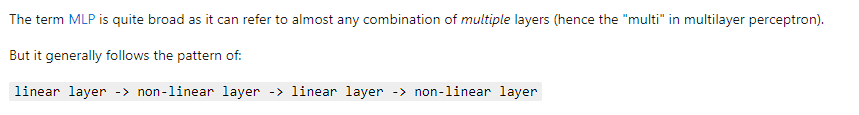

- "MLP contains 2 layers with a GELU non-linearity"
- In MLP there are fully connected layers (FC), with this you have to automatically think of nn.linear!
- The structure of MLP is that it includes a linear followed by a non-linear activation.
- In the training appendix it states there is dropout as well so, there should be after every LINEAR LAYER

Structure
- Linear
- GeLU
- Linear
- dropout = 0.1

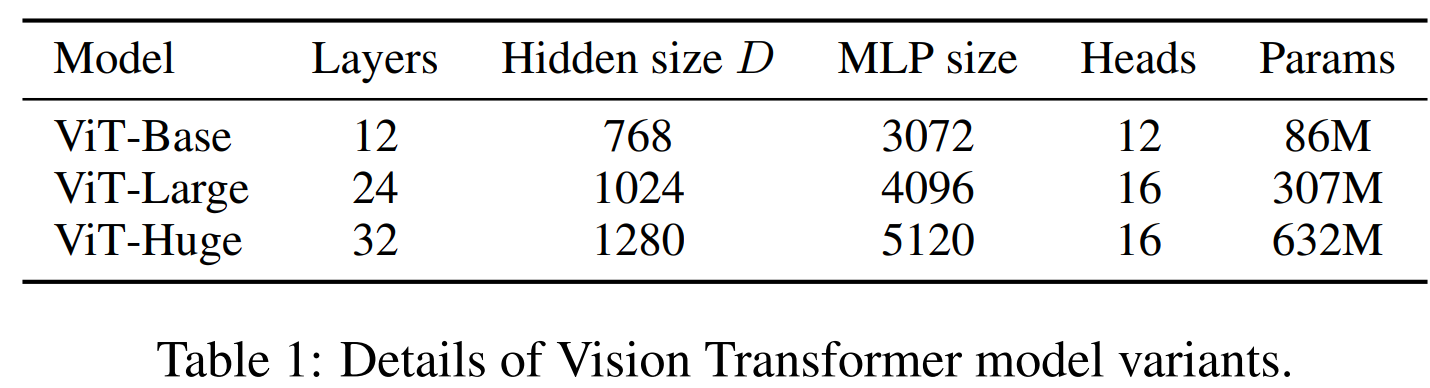

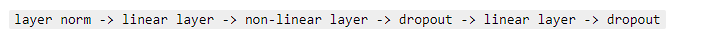

In [33]:
# We will create a class!

class MLPBlock(nn.Module):
  def __init__(self, embedding_din = 768, mlp_size = 3072, dropout = 0.1):
    super().__init__()

    self.norm = nn.LayerNorm(embedding_din)
    # self.Linear_Layer = nn.Linear(in_features = embedding_din, out_features = mlp_size)
    # self.dropout = nn.Dropout(p = dropout)
    # self.gelu = nn.GELU()
    # Or you can use sequential to do it!!!!!!!
    self.layers = nn.Sequential(
        nn.Linear(in_features = embedding_din, out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = dropout),
        # Notice how the input and output aligns!!
        nn.Linear(in_features = mlp_size, out_features = embedding_din),
        nn.Dropout(p = dropout)
    )
  def forward(self, x):
    x = self.norm(x)
    x = self.layers(x)
    return x

In [34]:
# create an instance first
mlp_block = MLPBlock()


# Within the layers, the shapes of tensors are expanded and contracted back to the embedding_dim size, so the output remoains thes ame

output_MLPBlock = mlp_block(patched_image_through_MSA)
output_MLPBlock.shape

torch.Size([1, 197, 768])

In [35]:
# To complete equation 3 add the residual!!!
output_MLPBlock_With_MSAOutput = output_MLPBlock + patched_image_through_MSA_Residual
output_MLPBlock_With_MSAOutput.shape

torch.Size([1, 197, 768])

## Important to note that input and output shape of the transformer encoder within ViT remains the same!!

---
## To build the transformer encoder block!
- Combining both MSA and MLP
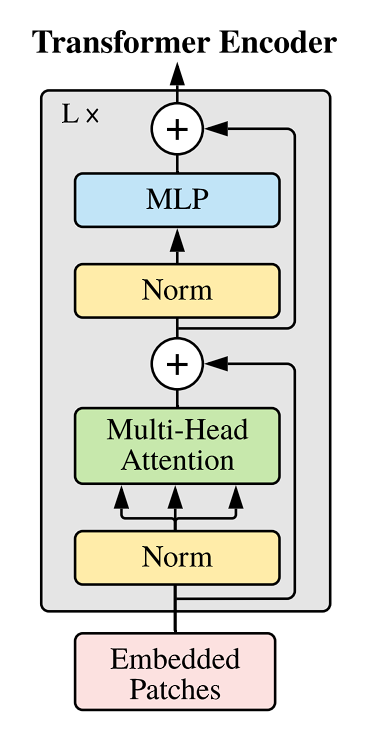

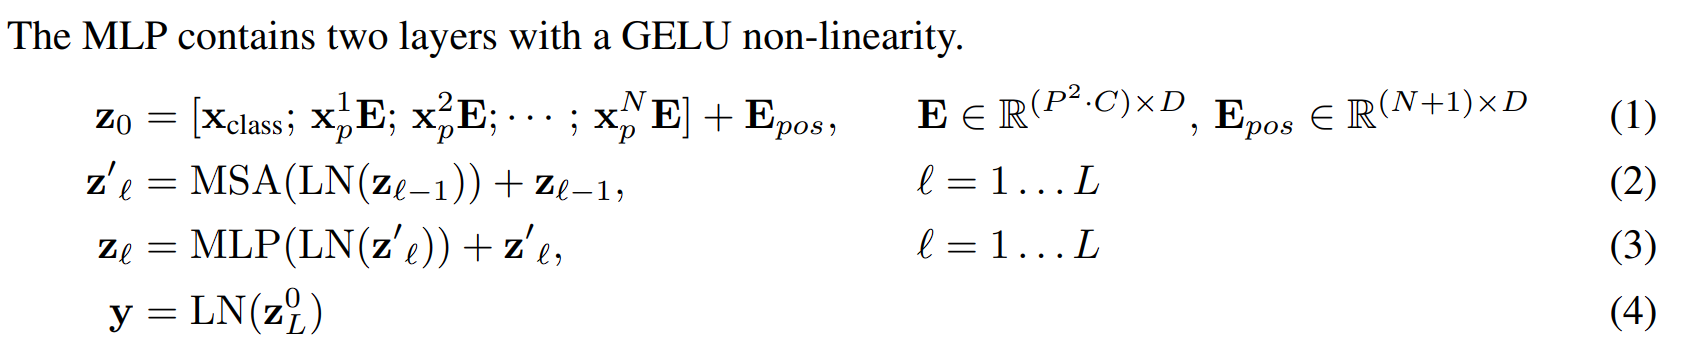

In [37]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self, embedding_size = 768, MLP_size = 3072, mlp_dropout = 0.1, MSA_heads = 12):
    super().__init__()

    # Create the intsance of both MSA and MLP block
    self.MSA_Block = MSAwNorm(embedding_size, MSA_heads)
    self.MLP_Block = MLPBlock(embedding_size, MLP_size, mlp_dropout)

  # In the forward part you have to add the residual as per the equation!
  def forward(self, x):
    x = self.MSA_Block(x) + x
    x = self.MLP_Block(x) + x
    return x

In [38]:
# We can see the parameters within it!

# Create an instance
transformer_encoder_block = TransformerEncoderBlock()

# Print the parameters
# summary(model=transformer_encoder_block,
#         input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])



Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MSAwNorm (MSA_Block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (norm)                            [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (msa)                    --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (MLP_Block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (norm)                            [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (layers)                         [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

-----
## To put all together!!
- Which includes the output part!

In [59]:
x = torch.rand((1, 197, 768))
y = x[:,0,:]
y.shape

torch.Size([1, 768])

In [65]:
# Transformation and eveything will be done here!
# This model class will take in an image and output a classification!
# So the patchifying ... will occur here!

class ViT(nn.Module):
  def __init__(self, img_size= 224,
               patch_size= 16, num_layers = 12,
               colour_channels =3, embedding_size = 768,
               MLP_size = 3072, mlp_dropout = 0.1,
               MSA_heads = 12, num_class = 3):
    super().__init__()

    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

    # 4. Calculate number of patches (height * width/patch^2)
    self.num_patches = (img_size * img_size) // patch_size**2
    # All the instances!!
    # For the patch embedding
    self.patch_embedding = PatchEmbedding(in_channels = colour_channels, patch_size = patch_size , embedding_dim=embedding_size)

    # Note that by default the learning, requires_grad = True!!! Is by default!
    # Add the learnable class embedding with the help fof random, make sure to pass through the randn.
    self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_size))

    # # Concatenate them together!
    # self.patch_cls_token = torch.cat((self.cls_token, self.patch_embedding.patch_embeddings), dim=1) # Concat to the first token!

    # Now you have to add the positional embeddings, where this you have to create with random also
    # num_patches + 1, because you want to add the positional emebedding to all of values in the tensor
    self.positional_embedding = nn.Parameter(torch.randn(1,self.num_patches+1,embedding_size))

    # # Then you will concat again!
    # self.patch_cls_positional_embedding = torch.cat((self.positional_embedding, self.patch_cls_token),dim= 1)

    # Now create the instance for the encoder block!
    # Note that there are >1 transformer encoder block to deal this we will use  nn.sequenatial with *
    self.encoder_block = nn.Sequential(*[TransformerEncoderBlock(embedding_size = embedding_size,
                                                                MLP_size = MLP_size,
                                                                mlp_dropout = mlp_dropout,
                                                                MSA_heads = MSA_heads)])

    # Then the classification block to deal with output!
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_size),
        nn.Linear(in_features=embedding_size,
                  out_features=num_class)
    )

    # Add the dropout
    self.embedding_dropout = nn.Dropout(p=mlp_dropout)

  def forward(self, x):
    # We have to get the batch of the input as we took it as 1 in the input!!!
    batch_size = x.shape[0]

    # we will then have to expand the class token to fit to the number of batches!
    cls_token = self.cls_token.expand(batch_size, -1, -1)

    x = self.patch_embedding(x)

    # Concate the class token and the X
    x = torch.cat((cls_token, x), dim=1)

    # Add the positional embedding with teh residual
    x = x + self.positional_embedding

    x = self.embedding_dropout(x)

    # Put through the encoder!
    x = self.encoder_block(x)

    # Now for the classifier block, we will take zeroth index of the output of encoder
    # So the class learnable thing is that one that leanrs what the output will be!!
    # So from the output of the encoder we will get the classification!
    x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

    return x


In [66]:
torch.manual_seed(42)

random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT()

# Pass the random image tensor to our ViT instan'ce
vit(random_image_tensor)

tensor([[-0.6018, -0.2991,  0.8392]], grad_fn=<AddmmBackward0>)